# Combining features from previous submission with their scaled counterparts

### Generation of features

Already implemented in featurize.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Set
from datetime import datetime as dt

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate
from plasticc.final import featurize_test, predict_test

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [4]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [5]:
%%time
meta_train = process_meta('../../data/raw/training_set_metadata.csv')
train = pd.read_csv('../../data/raw/training_set.csv')

CPU times: user 1.65 s, sys: 72 ms, total: 1.72 s
Wall time: 1.83 s


In [6]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=16)

Preprocessing time...
Fixing passband alignment...
Generating custom features...
Generating custom features for fixed passbands...
Custom features generated.


Feature Extraction: 100%|██████████| 80/80 [00:01<00:00, 70.47it/s]


CPU times: user 3min 25s, sys: 2.45 s, total: 3min 27s
Wall time: 3min 28s


In [7]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [8]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 32 ms, sys: 8 ms, total: 40 ms
Wall time: 40 ms


In [15]:
X.shape

(7848, 268)

In [16]:
y.shape

(7848,)

### Train model with CV

In [92]:
lgbm_params = {  # commented values were used for subm_610262... (slightly better, but more variance in feature importances)
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 6,
    'n_estimators': 2048,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.3,  # 0.33
    'drop_rate': 0.173,
    'learning_rate': 0.02137,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.75,  # 0.126
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 42,  # 32
    'min_data_in_leaf': 13,
    'lambda_l1': 3,  # 4
}

In [93]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])

colanmes_to_ignore_no_raw_data_peaks = colnames_to_ignore_very_restrictive | set([col for col in X.columns if 'peak' in col and 'fpb' in col])

id_colname = 'object_id'

In [94]:
feature_colnames = [col for col in X.columns if col not in colanmes_to_ignore_no_raw_data_peaks]

In [95]:
len(feature_colnames)

209

In [96]:
%%time
clfs, score, importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params={
        'lgbm': lgbm_params
    }, 
    nr_fold=6, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.407901	training's wloss: 0.901754	valid_1's multi_logloss: 1.75697	valid_1's wloss: 1.10522
[200]	training's multi_logloss: 0.203213	training's wloss: 0.573278	valid_1's multi_logloss: 1.3387	valid_1's wloss: 0.804508
[300]	training's multi_logloss: 0.14194	training's wloss: 0.442894	valid_1's multi_logloss: 1.14952	valid_1's wloss: 0.71033
[400]	training's multi_logloss: 0.112974	training's wloss: 0.370755	valid_1's multi_logloss: 1.04342	valid_1's wloss: 0.67651
[500]	training's multi_logloss: 0.0951605	training's wloss: 0.322949	valid_1's multi_logloss: 0.97613	valid_1's wloss: 0.664027
[600]	training's multi_logloss: 0.0824892	training's wloss: 0.287151	valid_1's multi_logloss: 0.927854	valid_1's wloss: 0.654817
[700]	training's multi_logloss: 0.0727948	training's wloss: 0.258869	valid_1's multi_logloss: 0.889816	valid_1's wloss: 0.654508
Early stopping, best iteration is:
[690]	trainin

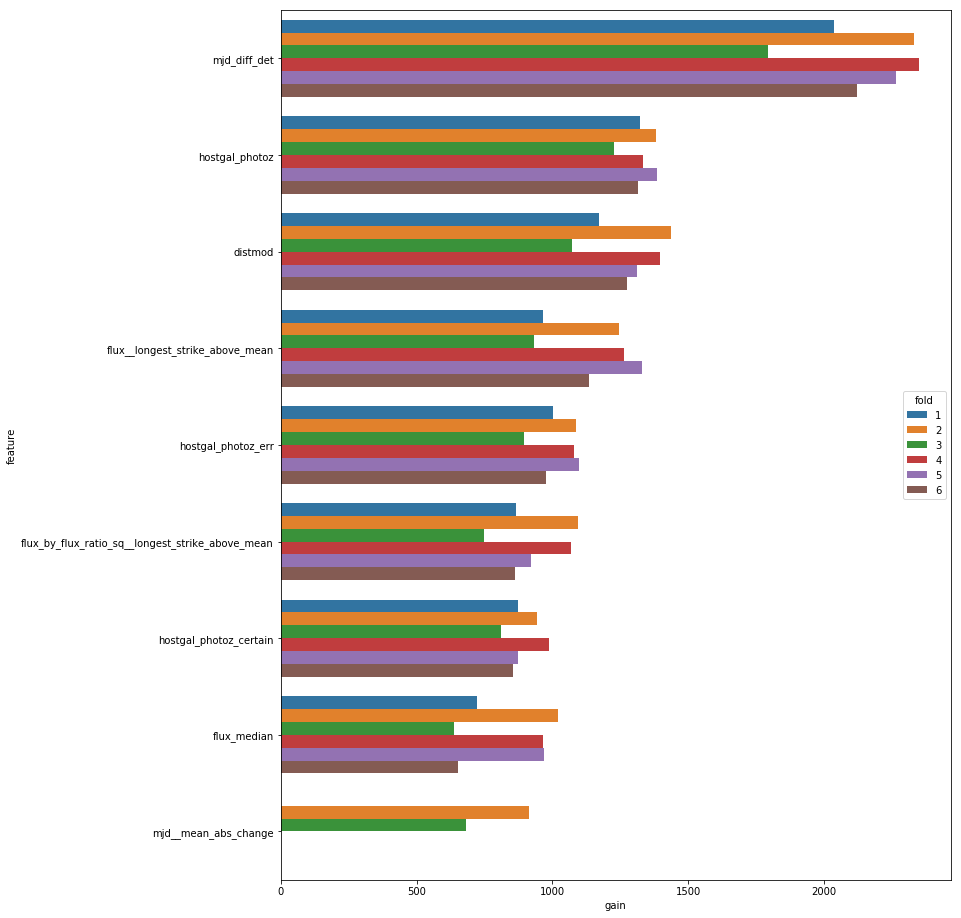

In [100]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).head(50), x='gain', y='feature', hue='fold', )
plt.show()

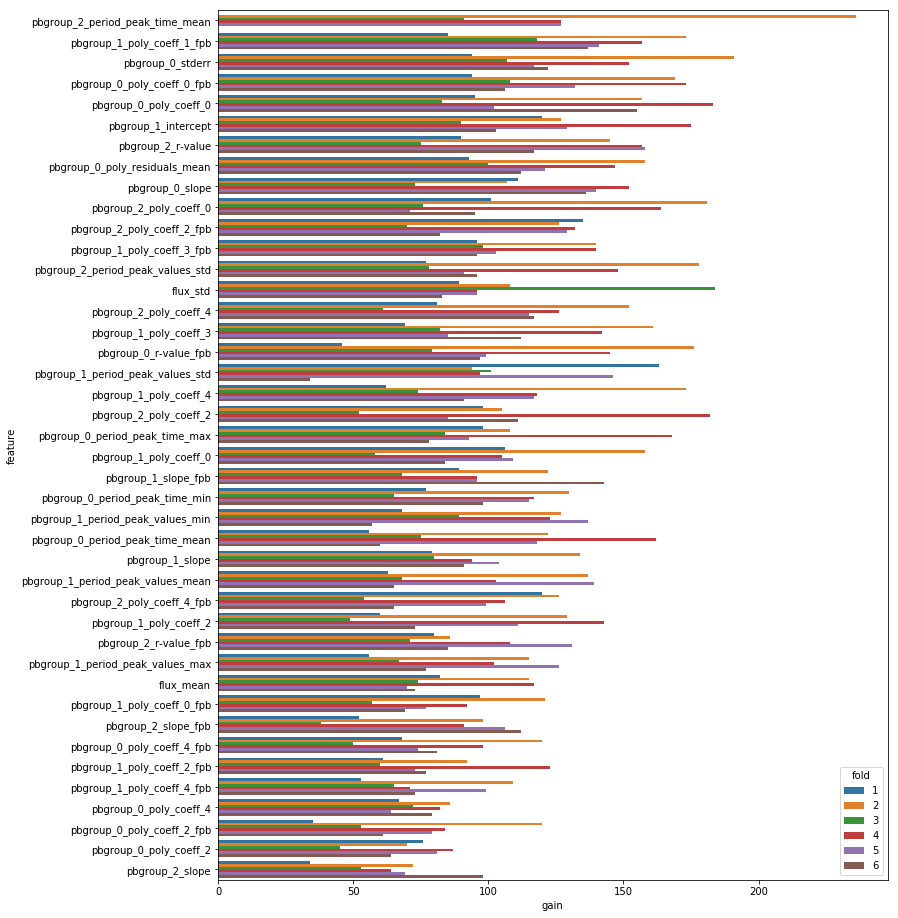

In [101]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).tail(250), x='gain', y='feature', hue='fold', )
plt.show()

In [102]:
importances.groupby('feature').mean().sort_values(by='mean_gain', ascending=False).tail(50)

,gain,fold,mean_gain
feature,,,
pbgroup_2_period_peak_time_max,139.666667,3.5,139.666667
mwebv,138.833333,3.5,138.833333
pbgroup_2_peak_time_max,137.666667,3.5,137.666667
pbgroup_1_peak_time_max,137.333333,3.5,137.333333
pbgroup_1_stderr,137.166667,3.5,137.166667
pbgroup_0_poly_residuals_mean_fpb,137.166667,3.5,137.166667
pbgroup_2_p-value_fpb,136.666667,3.5,136.666667
pbgroup_1_poly_residuals_mean_fpb,136.333333,3.5,136.333333
pbgroup_2_period_peak_time_mean,135.333333,3.5,135.333333


%%time
subm_dfs = []
for i_c, X_test in tqdm(enumerate(pd.read_csv('../../data/test-poly-with-kernel-and-scaling.csv', index_col=id_colname, chunksize=349289, iterator=True)), total=10):
    if 'object_id' in feature_colnames:
        raise KeyError('Cannot use object_id as a feature!')
    print("Loading data...")
    
    if not 'z_distance_approx' in set(X.columns)
    X_test['z_distance_approx'] = (X_test['hostgal_photoz']+1)**2

    print("Generating predictions...")
    subm = predict_chunk(X=X_test, features=feature_colnames, clfs=clfs, verbose=verbose)
    subm_dfs.append(subm)
# return subm_single

In [58]:
import os
from tqdm.autonotebook import tqdm

In [75]:
!ls ../../data/features-final/

test-3band-series-models-without-kernel-features-0.csv
test-3band-series-models-without-kernel-features-1.csv
test-3band-series-models-without-kernel-features-2.csv
test-3band-series-models-without-kernel-features-3.csv
test-3band-series-models-without-kernel-features-4.csv
test-3band-series-models-without-kernel-features-MISSED.csv


In [76]:
csv_dir = '../../data/features-final/'
csv_paths = [os.path.abspath(os.path.join(csv_dir, fname)) for fname in os.listdir(csv_dir) if not fname.startswith('.')]

In [77]:
%%time
csvs = [pd.read_csv(path) for path in csv_paths]

CPU times: user 1min 33s, sys: 9.94 s, total: 1min 43s
Wall time: 1min 43s


In [78]:
len(csvs)

6

In [79]:
csvs[0].shape

(673664, 137)

In [80]:
csvs[-1].shape

(35434, 137)

In [81]:
set(csvs[0].columns) - set(csvs[-1].columns)

set()

In [82]:
%%time
full_new_features = pd.concat(csvs, ignore_index=True)

CPU times: user 1.42 s, sys: 11.6 s, total: 13.1 s
Wall time: 13.1 s


In [83]:
print("Done")

Done


In [84]:
full_new_features['object_id'].head()

0    104853812
1    109643979
2    109643990
3    109644049
4    109644198
Name: object_id, dtype: int64

In [85]:
# %%time
# full_new_features['object_id'] = full_new_features['Unnamed: 0']
# del full_new_features['Unnamed: 0']

In [86]:
%%time
full_new_features = full_new_features.sort_values(by='object_id')

CPU times: user 2.26 s, sys: 24.8 s, total: 27.1 s
Wall time: 27.1 s


In [87]:
full_new_features['object_id'].head()

2912011    13
2912012    14
2912013    17
2912014    23
2912015    34
Name: object_id, dtype: int64

In [88]:
full_new_features['object_id'].tail()

1551218    130787966
1551219    130787971
1551220    130787974
1551221    130788053
2273939    130788054
Name: object_id, dtype: int64

In [89]:
%%time
full_new_features.index = full_new_features['object_id']
del full_new_features['object_id']

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 17.3 ms


In [90]:
full_new_features.head()

,"0__fft_coefficient__coeff_0__attr_""abs""_preprocessed","0__fft_coefficient__coeff_1__attr_""abs""_preprocessed",0__kurtosis_preprocessed,0__maximum_preprocessed,0__mean_abs_change_preprocessed,0__mean_change_preprocessed,0__minimum_preprocessed,0__skewness_preprocessed,"1__fft_coefficient__coeff_0__attr_""abs""_preprocessed","1__fft_coefficient__coeff_1__attr_""abs""_preprocessed",...,pbgroup_2_poly_coeff_1_fpb,pbgroup_2_poly_coeff_2_fpb,pbgroup_2_poly_coeff_3_fpb,pbgroup_2_poly_coeff_4_fpb,pbgroup_2_poly_residuals_max_fpb,pbgroup_2_poly_residuals_mean_fpb,pbgroup_2_poly_residuals_min_fpb,pbgroup_2_r-value_fpb,pbgroup_2_slope_fpb,pbgroup_2_stderr_fpb
object_id,,,,,,,,,,,,,,,,,,,,,
13,1275.514121,1043.183179,0.137475,74.435603,10.210332,0.148109,-22.070615,1.006924,50.481021,65.591719,...,-100.355597,139.522273,103.744946,-3.819939,8555.210445,8555.210445,8555.210445,0.748351,23.471380,2.080390
14,597.702454,402.995549,0.600015,39.538218,10.690306,-0.045670,-29.687218,0.278007,60.504554,69.700221,...,10.566722,-55.388797,-7.091392,12.127507,12680.025090,12680.025090,12680.025090,-0.370549,-6.395096,1.602987
17,733.323925,830.395899,2.767672,56.113448,12.875644,0.126909,-47.547976,0.256336,0.000000,0.000000,...,-11.736651,-15.155609,13.406239,10.534650,32234.260577,32234.260577,32234.260577,0.389518,9.966235,2.216834
23,785.517245,694.123342,4.901700,76.702340,12.259997,-0.057727,-34.528110,1.511056,2.123694,40.800082,...,11.954533,281.915969,-35.366900,-99.366657,19812.167808,19812.167808,19812.167808,0.049549,1.213089,2.445244
34,1962.518006,2028.888863,14.100532,239.794310,12.656241,-0.164516,-28.287242,3.830997,139.013983,117.919747,...,14.978577,-1167.791303,-42.752353,428.473686,159679.731491,159679.731491,159679.731491,0.067567,4.301150,5.974712


##### Prepare to join with previous features

In [44]:
%%time
df_prev = pd.read_csv('../../data/test-new-poly-with-kernel.csv')

CPU times: user 2min 51s, sys: 52.3 s, total: 3min 43s
Wall time: 3min 53s


In [91]:
set(df_prev['object_id']) == set(full_new_features.index)

True

In [92]:
missing_ids = sorted(list(set(df_prev['object_id'].unique()) - set(full_new_features.index)))

In [93]:
missing_ids[:10]

[]

In [94]:
missing_ids[-10:]

[]

##### WARNING: There are missing IDs, we need to inspect where the leak happend and find errors:

Generating missing features

In [67]:
missing_ids = set(missing_ids)

In [69]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [70]:
n_jobs=2
meta_path='../../data/raw/test_set_metadata.csv'
test_dir_path='../../data/raw-test-splits/'
output_path = '../../data/features-final/test-3band-series-models-without-kernel-features-MISSED.csv'
id_colname = 'object_id'

In [71]:
from plasticc.featurize import *

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

import multiprocessing as mp
import os
import sys

import gc
gc.enable()

In [72]:
%%time

df_meta = pd.read_csv(meta_path)

remain_df = None
saved = 0
for i_c, df in tqdm(enumerate(pd.read_csv(test_path, chunksize=chunks, iterator=True)), total=100):
    unique_ids = np.unique(df[id_colname])
    new_remain_df = df.loc[df[id_colname] == unique_ids[-1]].copy()
    if remain_df is None:
        df = df.loc[df[id_colname].isin(unique_ids[:-1])]
    else:
        df = pd.concat([remain_df, df.loc[df[id_colname].isin(unique_ids[:-1])]], axis=0)
    # Create remaining samples df
    remain_df = new_remain_df

    missing_only = df[df['object_id'].apply(lambda x: x in missing_ids)]
    if len(missing_only) == 0:
        continue
    
    preprocessed_df = preprocess_series(missing_only)
    redshift_series = pd.Series(df_meta['hostgal_photoz'].fillna(0).values, index=df_meta['object_id'])
    preprocessed_df = calculate_fixed_passband_and_scaled_flux(preprocessed_df, redshift_series)
    gc.collect()
    
    series_features_df = calculate_series_features(preprocessed_df, passband_colname='fixed_passband').add_suffix('_fpb')
    
    agg_df_ts_flux_passband_fpb = extract_features(
        preprocessed_df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='fixed_passband',
        column_value='flux',
        default_fc_parameters=fcp['flux_passband'], 
        n_jobs=n_jobs
    ).add_suffix('_preprocessed')
    agg_df_ts_flux_passband_fpb['object_id'] = agg_df_ts_flux_passband_fpb.index
    result = agg_df_ts_flux_passband_fpb.join(series_features_df, on='object_id')
    result.fillna(0, inplace=True)
    
    if saved == 0:
        result.to_csv(output_path, header=True, mode='w', index=True)
        saved = saved + 1
    else:
        result.to_csv(output_path, header=False, mode='a', index=True)
        saved = saved + 1

missing_only = remain_df[remain_df['object_id'].apply(lambda x: x in missing_ids)]
if len(missing_only) > 0:
    preprocessed_df = preprocess_series(missing_only)
    redshift_series = pd.Series(df_meta['hostgal_photoz'].fillna(0).values, index=df_meta['object_id'])
    preprocessed_df = calculate_fixed_passband_and_scaled_flux(preprocessed_df, redshift_series)
    gc.collect()
    
    series_features_df = calculate_series_features(preprocessed_df, passband_colname='fixed_passband').add_suffix('_fpb')
    
    agg_df_ts_flux_passband_fpb = extract_features(
        preprocessed_df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='fixed_passband',
        column_value='flux',
        default_fc_parameters=fcp['flux_passband'], 
        n_jobs=n_jobs
    ).add_suffix('_preprocessed')
    agg_df_ts_flux_passband_fpb['object_id'] = agg_df_ts_flux_passband_fpb.index
    result = agg_df_ts_flux_passband_fpb.join(series_features_df, on='object_id')
    result.fillna(0, inplace=True)
    
    if saved == 0:
        result.to_csv(output_path, header=True, mode='w', index=True)
        saved = saved + 1
    else:
        result.to_csv(output_path, header=False, mode='a', index=True)
        saved = saved + 1

Feature Extraction: 100%|██████████| 10/10 [01:05<00:00,  6.39s/it]



CPU times: user 13min 27s, sys: 19.9 s, total: 13min 47s
Wall time: 14min 35s


In [73]:
print("Done")

Done


In [74]:
saved

1

Go back, reload array of CSVs and check whether indices match this time (they should)

##### Perform the actual join

In [96]:
%%time
df_full_feat = df_prev.join(full_new_features, on='object_id')

CPU times: user 3.88 s, sys: 40.5 s, total: 44.3 s
Wall time: 44.3 s


In [97]:
df_full_feat.shape

(3492890, 292)

In [98]:
df_full_feat.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,...,pbgroup_2_poly_coeff_1_fpb,pbgroup_2_poly_coeff_2_fpb,pbgroup_2_poly_coeff_3_fpb,pbgroup_2_poly_coeff_4_fpb,pbgroup_2_poly_residuals_max_fpb,pbgroup_2_poly_residuals_mean_fpb,pbgroup_2_poly_residuals_min_fpb,pbgroup_2_r-value_fpb,pbgroup_2_slope_fpb,pbgroup_2_stderr_fpb
0,13,-12.680235,42.765503,3.997127,0.616561,9.149645,2.037355,0.691634,11.257108,2.461810,...,-100.355597,139.522273,103.744946,-3.819939,8555.210445,8555.210445,8555.210445,0.748351,23.471380,2.080390
1,14,-11.142164,14.839427,0.884047,0.072856,3.399946,0.970525,0.690589,11.249375,2.457580,...,10.566722,-55.388797,-7.091392,12.127507,12680.025090,12680.025090,12680.025090,-0.370549,-6.395096,1.602987
2,17,-14.202744,16.761280,0.791032,0.458390,3.886578,0.377131,0.663680,11.278636,2.702947,...,-11.736651,-15.155609,13.406239,10.534650,32234.260577,32234.260577,32234.260577,0.389518,9.966235,2.216834
3,23,-12.631923,28.061138,0.970396,0.465986,4.100713,2.177402,0.697639,11.305429,2.480364,...,11.954533,281.915969,-35.366900,-99.366657,19812.167808,19812.167808,19812.167808,0.049549,1.213089,2.445244
4,34,-13.239577,124.475609,4.580070,0.301366,19.862714,4.537527,0.679312,11.365292,2.746784,...,14.978577,-1167.791303,-42.752353,428.473686,159679.731491,159679.731491,159679.731491,0.067567,4.301150,5.974712


In [101]:
%%time
df_full_feat.to_csv('../../data/test-poly-with-kernel-and-scaling.csv', index=False)

CPU times: user 23min 59s, sys: 17.7 s, total: 24min 17s
Wall time: 24min 18s


In [102]:
print("Done")

Done


### Check feature alignment between train and test

In [39]:
[col for col in feature_colnames if col not in set(df_full_feat.columns)]

NameError: name 'df_full_feat' is not defined

In [107]:
%%time
df_full_feat['z_distance_approx'] = (df_full_feat['hostgal_photoz']+1)**2

CPU times: user 24 ms, sys: 24 ms, total: 48 ms
Wall time: 46.3 ms


In [110]:
# check once again to make sure everything went well
[col for col in feature_colnames if col not in set(df_full_feat.columns)] == []

True

### Generate predictions on the test set by reading CSV chunk by chunk

In [103]:
submission_file_path = path_from_cv_score(score)
submission_file_path

'/home/kk385830/astronomical-classification/submissions/subm_0.610554_2018-12-18-00-37.csv'

In [104]:
from plasticc.final import *

In [105]:
import gc
import time
from typing import List
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
from tqdm import tqdm

from plasticc.featurize import process_meta, featurize

np.warnings.filterwarnings('ignore')
gc.enable()

In [106]:
# def predict_test(
clfs=clfs
feature_colnames=feature_colnames
id_colname=id_colname
output_path=path_from_cv_score(score)
class_99_target_mean=0.12
verbose=True

In [107]:
print(output_path)

/home/kk385830/astronomical-classification/submissions/subm_0.610554_2018-12-18-00-37.csv


In [108]:
%%time
subm_dfs = []
for i_c, X_test in tqdm(enumerate(pd.read_csv('../../data/test-poly-with-kernel-and-scaling.csv', index_col=id_colname, chunksize=349289, iterator=True)), total=10):
    if 'object_id' in feature_colnames:
        raise KeyError('Cannot use object_id as a feature!')
    print("Loading data...")
    
    print("Missing columns (z_distance_approx will be fixed automatically):", [col for col in feature_colnames if col not in set(X_test.columns)])
    
    if not 'z_distance_approx' in X_test.columns:
        X_test['z_distance_approx'] = (X_test['hostgal_photoz']+1)**2

    print("Generating predictions...")
    subm = predict_chunk(X=X_test, features=feature_colnames, clfs=clfs, verbose=verbose)
    subm_dfs.append(subm)
# return subm_single

  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



  0%|          | 0/6 [00:00<?, ?it/s]

Loading data...
Missing columns (z_distance_approx will be fixed automatically): ['z_distance_approx']
Generating predictions...



100%|██████████| 10/10 [25:10<00:00, 148.18s/it]

CPU times: user 4h 17min 39s, sys: 1min 42s, total: 4h 19min 22s
Wall time: 25min 10s


In [72]:
%%time
subm = pd.concat(subm_dfs, axis=0)

CPU times: user 840 ms, sys: 236 ms, total: 1.08 s
Wall time: 1.07 s


In [73]:
subm.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.000079,0.000869,0.000041,0.293590,0.582731,0.000147,0.053809,0.000094,0.000044,0.002846,0.000173,0.065024,0.000060,0.000494,13,0.259505
1,0.000100,0.004061,0.000076,0.082438,0.043586,0.000217,0.065879,0.000283,0.000243,0.058675,0.000419,0.707193,0.000093,0.036737,14,0.216452
2,0.000163,0.003674,0.000156,0.065530,0.060429,0.000339,0.017775,0.004696,0.000170,0.066093,0.002044,0.754176,0.000107,0.024646,17,0.190923
3,0.000092,0.001405,0.000082,0.054546,0.022964,0.000208,0.046439,0.005904,0.000131,0.254741,0.000228,0.457194,0.000068,0.155999,23,0.298305
4,0.000041,0.001183,0.000026,0.057741,0.169843,0.000094,0.023194,0.000112,0.000051,0.021842,0.000046,0.725605,0.000032,0.000191,34,0.204717


In [74]:
subm.shape

(3492890, 16)

In [75]:
subm_bkp = subm.copy()

In [76]:
%%time
print("Postprocessing...")
# bagging - compute mean prediction from all clfs for each object_id
print(f"Submission shape before grouping: {subm.shape}")
subm_single = subm.groupby('object_id').mean()
print(f"Submission shape after grouping: {subm_single.shape}")
# scale class_99 mean to match the desired value before normalizing other classes
class_99_mean = subm_single['class_99'].mean()
print(f"Class 99 mean probability before normalization: {class_99_mean}")
scaling_factor = class_99_target_mean / class_99_mean
subm_single['class_99'] = subm_single['class_99'] * scaling_factor
print(f"Class 99 mean probability after normalization: {subm_single['class_99'].mean()}")
# normalization - all classes' probabilities should be equal to 1.0 for each object_id
subm_sum = subm_single.sum(axis=1)
for col in subm_single.columns:
    subm_single[col] = subm_single[col] / subm_sum
max_err = np.max(np.abs(subm_single.sum(axis=1).values - 1.0))
if max_err > 1e-15:
    print(f"Warning: high error in submission normalization: {max_err}")
# round all predictions to float32 so that CSV is twice smaller (Kaggle uses 32-bit accuracy to calculate score anyway)
subm_single = subm_single.round(decimals=8).astype(np.float32)
# make sure index is typed correctly
subm_single.index = subm_single.index.astype(np.int)
print(f"Submission shape after postprocessing: {subm_single.shape}")

print('Validating submission file...')
if not subm_single.shape == (3492890, 15):
    print("Invalid shape")
#     return subm_single
if not subm_single.index.dtype == np.int:
    print("Invalid index")
#     return subm_single

Postprocessing...
Submission shape before grouping: (3492890, 16)
Submission shape after grouping: (3492890, 15)
Class 99 mean probability before normalization: 0.24785152852286133
Class 99 mean probability after normalization: 0.11999999999999991
Submission shape after postprocessing: (3492890, 15)
Validating submission file...
CPU times: user 3.3 s, sys: 800 ms, total: 4.1 s
Wall time: 4.1 s


In [78]:
subm.index = subm['object_id']
del subm['object_id']

In [79]:
subm.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000079,0.000869,0.000041,0.293590,0.582731,0.000147,0.053809,0.000094,0.000044,0.002846,0.000173,0.065024,0.000060,0.000494,0.259505
14,0.000100,0.004061,0.000076,0.082438,0.043586,0.000217,0.065879,0.000283,0.000243,0.058675,0.000419,0.707193,0.000093,0.036737,0.216452
17,0.000163,0.003674,0.000156,0.065530,0.060429,0.000339,0.017775,0.004696,0.000170,0.066093,0.002044,0.754176,0.000107,0.024646,0.190923
23,0.000092,0.001405,0.000082,0.054546,0.022964,0.000208,0.046439,0.005904,0.000131,0.254741,0.000228,0.457194,0.000068,0.155999,0.298305
34,0.000041,0.001183,0.000026,0.057741,0.169843,0.000094,0.023194,0.000112,0.000051,0.021842,0.000046,0.725605,0.000032,0.000191,0.204717


In [81]:
%%time
if output_path is None:
    print('WTF')
#     break
    3//0
print("Saving submission...")
try:
    subm_single.to_csv(output_path, index=True)
    print(f"Submission saved to f{output_path}")
except Exception as e:
    print(e)

Saving submission...
Submission saved to f/home/kk385830/astronomical-classification/submissions/subm_0.610262_2018-12-17-23-52.csv
CPU times: user 59.9 s, sys: 440 ms, total: 1min
Wall time: 1min


In [21]:
# previously used version with call and load from CSV:

# %%time
# submission = predict_test(
#     clfs=clfs, 
#     feature_colnames=feature_colnames, 
#     id_colname=id_colname, 
#     input_path='../../data/test-new-poly-with-kernel.csv', 
#     output_path=submission_file_path, 
#     class_99_target_mean=0.12,
#     verbose=True
# )

Loading data...


  0%|          | 0/6 [00:00<?, ?it/s]

Generating predictions...


100%|██████████| 6/6 [15:53<00:00, 165.67s/it]


Postprocessing...
Submission shape before grouping: (3492890, 16)
Submission shape after grouping: (3492890, 15)
Submission shape after postprocessing: (3492890, 15)
Validating submission file...
Saving submission...
Submission saved to f/home/kk385830/astronomical-classification/submissions/subm_0.603058_2018-12-16-18-13.csv
CPU times: user 3h 50min 6s, sys: 1min 25s, total: 3h 51min 32s
Wall time: 19min 19s


In [1]:
submission.head(3)

NameError: name 'submission' is not defined

In [51]:
submission['class_99'].mean()

0.13013586

In [52]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000040,0.000354,0.000024,0.357446,0.379110,0.000061,0.050607,0.000019,0.000019,0.001214,0.000070,0.058122,0.000033,0.000267,0.152613
14,0.000060,0.002804,0.000055,0.114822,0.033061,0.000089,0.031412,0.000075,0.000322,0.015856,0.000227,0.679401,0.000058,0.014515,0.107244
17,0.000151,0.004765,0.000147,0.087640,0.054351,0.000197,0.015882,0.001972,0.000218,0.097757,0.001537,0.576313,0.000076,0.026642,0.132353
23,0.000080,0.001103,0.000092,0.054336,0.013861,0.000125,0.050159,0.006378,0.000147,0.186823,0.000155,0.508671,0.000044,0.033623,0.144404
34,0.000018,0.000605,0.000017,0.040403,0.162473,0.000038,0.012966,0.000023,0.000040,0.004567,0.000024,0.669535,0.000014,0.000119,0.109158


### Quick check reny entropy mean class 99 probabilities

In [12]:
submission = pd.read_csv('../../submissions/subm_0.603058_2018-12-16-18-13.csv', index_col='object_id')

In [13]:
def renyEntropy(alpha, vector):
    if alpha < 0 or alpha == 1:
        raise Exception('alpha must not be 1 neither negative')

    coeff = 1 / (1 - alpha)
    powered = vector ** alpha
    sumpow = np.sum(powered, axis=1)
    logof = np.log(sumpow) / np.log(13)
    return logof * coeff

In [14]:
reny_99 = renyEntropy(10, submission.values) * 0.25

In [15]:
submission['class_99'] = (submission['class_99'].values + reny_99) / 2

In [16]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000040,0.000354,0.000024,0.357446,0.379110,0.000061,0.050607,0.000019,0.000019,0.001214,0.000070,0.058122,0.000033,0.000267,0.126435
14,0.000060,0.002804,0.000055,0.114822,0.033061,0.000089,0.031412,0.000075,0.000322,0.015856,0.000227,0.679401,0.000058,0.014515,0.074553
17,0.000151,0.004765,0.000147,0.087640,0.054351,0.000197,0.015882,0.001972,0.000218,0.097757,0.001537,0.576313,0.000076,0.026642,0.096018
23,0.000080,0.001103,0.000092,0.054336,0.013861,0.000125,0.050159,0.006378,0.000147,0.186823,0.000155,0.508671,0.000044,0.033623,0.108804
34,0.000018,0.000605,0.000017,0.040403,0.162473,0.000038,0.012966,0.000023,0.000040,0.004567,0.000024,0.669535,0.000014,0.000119,0.076302


In [17]:
submission.sum(axis=1).head()

object_id
13    0.973822
14    0.967309
17    0.963665
23    0.964400
34    0.967144
dtype: float64

In [18]:
# normalization - all classes' probabilities should be equal to 1.0 for each object_id
subm_sum = submission.sum(axis=1)
for col in submission.columns:
    submission[col] = submission[col] / subm_sum
max_err = np.max(np.abs(submission.sum(axis=1).values - 1.0))
if max_err > 1e-7:
    print(f"Warning: high error in submission normalization: {max_err}")
# round all predictions to float32 so that CSV is twice smaller (Kaggle uses 32-bit accuracy to calculate score anyway)
submission = submission.round(decimals=8).astype(np.float32)
# make sure index is typed correctly
submission.index = submission.index.astype(np.int)
print(f"Submission shape after postprocessing: {submission.shape}")

Submission shape after postprocessing: (3492890, 15)


In [19]:
submission.to_csv('../../submissions/subm_0.603058_2018-12-16-18-13_quarter_reny_with_previous_99_avg.csv')

In [21]:
submission.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000041,0.000363,0.000025,0.367055,0.389301,0.000063,0.051967,0.000019,0.000019,0.001247,0.000072,0.059684,0.000034,0.000275,0.129834
14,0.000062,0.002898,0.000057,0.118703,0.034178,0.000092,0.032474,0.000077,0.000332,0.016392,0.000235,0.702363,0.000060,0.015005,0.077073
17,0.000157,0.004944,0.000153,0.090945,0.056401,0.000205,0.016481,0.002046,0.000226,0.101443,0.001595,0.598042,0.000078,0.027647,0.099638
23,0.000083,0.001144,0.000096,0.056342,0.014372,0.000129,0.052011,0.006613,0.000152,0.193720,0.000160,0.527448,0.000046,0.034865,0.112820
34,0.000018,0.000626,0.000018,0.041776,0.167992,0.000039,0.013406,0.000024,0.000041,0.004722,0.000025,0.692281,0.000015,0.000123,0.078894


In [23]:
submission['class_99'].mean()

0.10975695